# Videos and Exercises for Session 12: Model Selection and Cross-Validation

In this combined teaching module and exercise set, we will investigate how to optimize the choice of hyperparameters using model validation and cross validation. As an aside, we will see how to build machine learning models using a formalized pipeline from preprocessed (i.e. tidy) data to a model.

The structure of this notebook is as follows:
1. Model Building with Pipelines
2. Model Selection and Validation
    - Simple Validation
    - Cross Validation
    - Tools for Model Selection

## Packages
First, we need to import our standard stuff. Notice that (similar to last session), we are not interested in seeing the convergence warning in scikit-learn, so we suppress them for now.

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

# Part 1: Model Building with Pipelines

A powerful tool for making and applying models are pipelines, which allows to combine different preprocessing and model procedures into one. This has many advantages, mainly being more safe but also has the added side effect being more code-efficient.

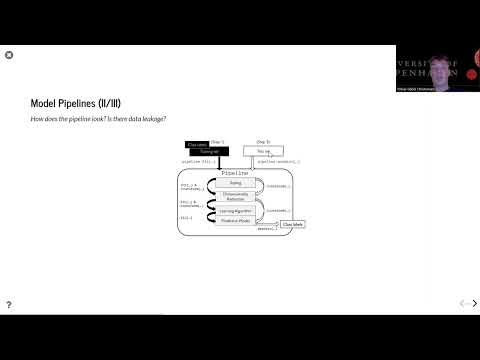

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('e_98Co2xRuQ', width=640, height=360)


First, load the housing dataset from Ex. 11.2.0 using the code below. 

In [9]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

cal_house = fetch_california_housing()    
X = pd.DataFrame(data=cal_house['data'], 
                 columns=cal_house['feature_names'])\
             .iloc[:,:-2]
y = cal_house['target']

> **Ex. 12.1.1:** Construct a model building pipeline which: 
> 1. adds polynomial features of degree 3 without bias;
> 2. scales the features to mean zero and unit std. 

> *Hint:* a modelling pipeline can be constructed with `make_pipeline` from `sklearn.pipeline`.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Create the pipeline
pipeline = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),  # Add polynomial features of degree 3
    StandardScaler()  # Scale the features to mean zero and unit std
)

# Fit and transform the data using the pipeline
X_transformed = pipeline.fit_transform(X)

Now X_transformed contains the polynomial features of degree 3, scaled as specified.

# Part 2: Model Selection and Validation


## Simple Validation
In machine learning, we have two types of parameters: those that are learned from
the training data, for example, the weights in logistic regression, and the parameters
of a learning algorithm that are optimized separately. The latter are the tuning
parameters, also called *hyperparameters*, of a model. These could for example be the regularization
parameter in logistic regression or the depth parameter of a decision tree.

Below, we investigate how we can choose optimal hyperparameters.

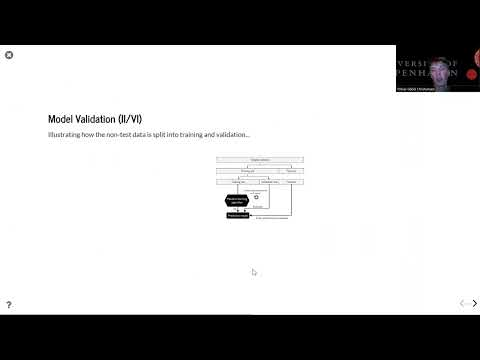

In [11]:
YouTubeVideo('jSPGLkxJ0cQ', width=640, height=360)

In what follows, we will regard the "train" (aka. development, non-test) data for two purposes. 
- First we are interested in getting a credible measure of models under different hyperparameters to perform a model selection. 
- Then - with the selected model - we estimate/train it on all the training data. 

> **Ex. 12.2.1:** Make a for loop with 10 iterations where you:
> 1. Split the input data into, train (also know as development) and test where the test sample should be one third. Set a new random state for each iteration of the loop, so each iteration makes a different split.
> 2. Further split the training (aka development) data into two even sized bins; the first data is for training models and the other is for validating them. Therefore these data sets are often called training and validation.
> 3. Train a linear regression model with sub-training data. Compute the RMSE for out-of-sample predictions for both the test data  and the validation data. Save the RMSE.
>
> You should now have a 10x2 DataFrame with 10 RMSE from both the test data set and the train data set. Compute descriptive statistics of RMSE for the out-of-sample predictions on test and validation data. Are they simular?    
>   They hopefuly are pretty simular. This shows us, that we can split the train data, and use this to fit the model. 
>
> *Hint*: you can reuse any code used to solve e.g. exercises 11.3.2.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the dataset
cal_house = fetch_california_housing()
X = pd.DataFrame(data=cal_house['data'], columns=cal_house['feature_names']).iloc[:,:-2]
y = cal_house['target']

# Create a DataFrame to store RMSE values
rmse_df = pd.DataFrame(columns=['Test RMSE', 'Validation RMSE'])

# Perform 10 iterations
for iteration in range(10):
    # Split the data into train (development) and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=iteration)
    
    # Further split the training (development) data into training and validation sets
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=iteration)
    
    # Create the pipeline
    pipeline = make_pipeline(
        PolynomialFeatures(degree=3, include_bias=False),  # Add polynomial features of degree 3
        StandardScaler(),  # Scale the features to mean zero and unit std
        LinearRegression()  # Linear Regression model
    )
    
    # Train the model on the sub-training data
    pipeline.fit(X_train_sub, y_train_sub)
    
    # Make predictions on the test data and validation data
    y_test_pred = pipeline.predict(X_test)
    y_val_pred = pipeline.predict(X_val)
    
    # Compute RMSE for test and validation predictions
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # Store RMSE values in the DataFrame
    rmse_df.loc[iteration] = [rmse_test, rmse_val]

# Calculate descriptive statistics of RMSE for test and validation predictions
rmse_stats = rmse_df.describe()
print(rmse_stats)


          Test RMSE  Validation RMSE
count     10.000000        10.000000
mean    5470.667292     26887.660396
std    10947.071375     83191.198341
min        0.919830         3.171849
25%        6.164023       100.845344
50%      846.550198       265.431451
75%     2175.457638      1349.432350
max    33849.919521    263644.614511


> **Ex. 12.2.2:** Construct a model building pipeline which 
> 1. adds polynomial features of degree 3 without bias;
> 2. scales the features to mean zero and unit std. 
> 3. estimates a Lasso model

In [14]:
from sklearn.linear_model import Lasso

# Load the dataset
cal_house = fetch_california_housing()
X = pd.DataFrame(data=cal_house['data'], columns=cal_house['feature_names']).iloc[:,:-2]
y = cal_house['target']

# Create a DataFrame to store RMSE values
rmse_df = pd.DataFrame(columns=['Test RMSE', 'Validation RMSE'])

# Perform 10 iterations
for iteration in range(10):
    # Split the data into train (development) and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=iteration)
    
    # Further split the training (development) data into training and validation sets
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=iteration)
    
    # Create the pipeline
    pipeline = make_pipeline(
        PolynomialFeatures(degree=3, include_bias=False),  # Add polynomial features of degree 3
        StandardScaler(),  # Scale the features to mean zero and unit std
        Lasso(alpha=1.0)  # Lasso regression model with alpha=1.0
    )
    
    # Train the model on the sub-training data
    pipeline.fit(X_train_sub, y_train_sub)
    
    # Make predictions on the test data and validation data
    y_test_pred = pipeline.predict(X_test)
    y_val_pred = pipeline.predict(X_val)
    
    # Compute RMSE for test and validation predictions
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # Store RMSE values in the DataFrame
    rmse_df.loc[iteration] = [rmse_test, rmse_val]

# Calculate descriptive statistics of RMSE for test and validation predictions
rmse_stats = rmse_df.describe()
print(rmse_stats)


       Test RMSE  Validation RMSE
count  10.000000        10.000000
mean    1.154631         1.154159
std     0.011231         0.007989
min     1.136473         1.141985
25%     1.145537         1.147605
50%     1.155531         1.154263
75%     1.162058         1.158934
max     1.171695         1.166407


## Cross Validation

  
The simple validation procedure that we outlined above has one disadvantage: it only uses parts of the *development* data for validation. In the video below, we present a refined approach that uses all the *development* for validation.



In [ ]:
YouTubeVideo('-G--B3woZGU', width=640, height=360)

When we want to optimize over both normal parameters and hyperparameters, we do this using nested loops (two-layered cross validation). In the outer loop, we vary the hyperparameters, and then in the inner loop, we do cross validation for the model with the specific selection of hyperparameters. This way, we can find the model with the lowest mean MSE. 

> **Ex. 12.2.3:**
Run a Lasso regression using the Pipeline from `Ex 12.2.2`. In the outer loop, search through the lambdas specified below. 
In the inner loop, make *5 fold cross validation* on the selected model and store the average MSE for each fold. Which lambda, from the selection below, gives the lowest test MSE?
>  ```python 
> lambdas =  np.logspace(-4, 4, 12)
> ```
> *Hint:* `KFold` in `sklearn.model_selection` may be useful.

In [17]:
from sklearn.model_selection import train_test_split, KFold

# Define lambda values to search through
lambdas = np.logspace(-4, 4, 12)

# Create a DataFrame to store average MSE for each lambda
mse_df = pd.DataFrame(index=lambdas, columns=['Average MSE'])

# Outer loop for varying lambdas
for lambda_val in lambdas:
    avg_mse_list = []  # Store average MSE values for each fold
    
    # Inner loop for 5-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_indices, val_indices in kfold.split(X):
        X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]
        
        # Create the pipeline with the current lambda value
        pipeline = make_pipeline(
            PolynomialFeatures(degree=3, include_bias=False),  # Add polynomial features of degree 3
            StandardScaler(),  # Scale the features to mean zero and unit std
            Lasso(alpha=lambda_val)  # Lasso regression model with the current lambda value
        )
        
        # Train the model on the training data
        pipeline.fit(X_train, y_train)
        
        # Make predictions on the validation data
        y_val_pred = pipeline.predict(X_val)
        
        # Calculate MSE for the fold and store it
        mse_fold = mean_squared_error(y_val, y_val_pred)
        avg_mse_list.append(mse_fold)
    
    # Calculate the average MSE across folds for the current lambda
    avg_mse = np.mean(avg_mse_list)
    
    # Store the average MSE in the DataFrame
    mse_df.loc[lambda_val, 'Average MSE'] = avg_mse

# Find the lambda with the lowest average MSE
best_lambda = mse_df['Average MSE'].astype(float).idxmin()
print(f"The lambda with the lowest average MSE: {best_lambda}")


The lambda with the lowest average MSE: 0.08111308307896872


In [18]:
X.iloc[:,1]

0        41.0
1        21.0
2        52.0
3        52.0
4        52.0
         ... 
20635    25.0
20636    18.0
20637    17.0
20638    18.0
20639    16.0
Name: HouseAge, Length: 20640, dtype: float64

## Tools for model selection

Below we review three useful tools for performing model selection. The first tool, the learning curve, can be used to assess whether there is over- and underfitting.

In [ ]:
YouTubeVideo('BMR6O9NaYdc', width=640, height=360)

The next tool, the validation curve, helps to make perform automated model selection and to visualize the process of model selection.

In [ ]:
YouTubeVideo('c9NkJC7EzPg', width=640, height=360)

**Explanation of lambda from the video above**: As we increase lambda, we get a more simple model. Increasing lambda means increasing the degree of regularization; we increase the weight put on the penalty term in the cost function. The more weight we put on it, the more features will be shut down, that is, the coefficients will be set to zero. When the train curve is below the validation curve by a big amount, we are overfitting. When the two curves have converged and have both become flat, we are underfitting.

When we have more than one hyperparameter, we need to find the combination of optimal hyperparameters. In the video below we see how to do that for *elastic net*, which has both L1 and L2 regularization.

In [ ]:
YouTubeVideo('AjEpa24mFGw', width=640, height=360)

> **Ex. 12.2.4:** __Automated Cross Validation in one dimension__  
Now we want to repeat exercise 12.2.3 in a more automated fashion. 
When you are doing cross validation with one hyperparameter, you can automate the process by using `validation_curve` from `sklearn.model_selection`. Use this function to search through the values of lambdas, and find the value of lambda, which give the lowest test error.  
>
> Check if you got the same output for the manual implementation (Ex. 12.2.3) and the automated implementation (Ex. 12.2.4) 
>
> BONUS: Plot the average MSE-test and MSE-train against the different values of lambda. (*Hint*: Use logarithmic axes, and lambda as index)

In [21]:
from sklearn.model_selection import train_test_split, validation_curve


# Define lambda values to search through
lambdas = np.logspace(-4, 4, 12)

# Calculate validation curve
train_scores, test_scores = validation_curve(
    estimator=pipeline, X=X, y=y, param_name='lasso__alpha', param_range=lambdas,
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

# Convert the scores to positive mean squared error
train_mse = -train_scores
test_mse = -test_scores

# Calculate the mean MSE across cross-validation folds
mean_train_mse = np.mean(train_mse, axis=1)
mean_test_mse = np.mean(test_mse, axis=1)

# Find the lambda with the lowest mean test MSE
best_lambda_auto = lambdas[np.argmin(mean_test_mse)]
print(f"The best lambda found using automated validation_curve: {best_lambda_auto}")


/Users/ninajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.847e+01, tolerance: 2.228e+00
  model = cd_fast.enet_coordinate_descent(
/Users/ninajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.413e+03, tolerance: 2.228e+00
  model = cd_fast.enet_coordinate_descent(
/Users/ninajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

The best lambda found using automated validation_curve: 0.08111308307896872


/Users/ninajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.291e+03, tolerance: 2.128e+00
  model = cd_fast.enet_coordinate_descent(
/Users/ninajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.342e+02, tolerance: 2.128e+00
  model = cd_fast.enet_coordinate_descent(


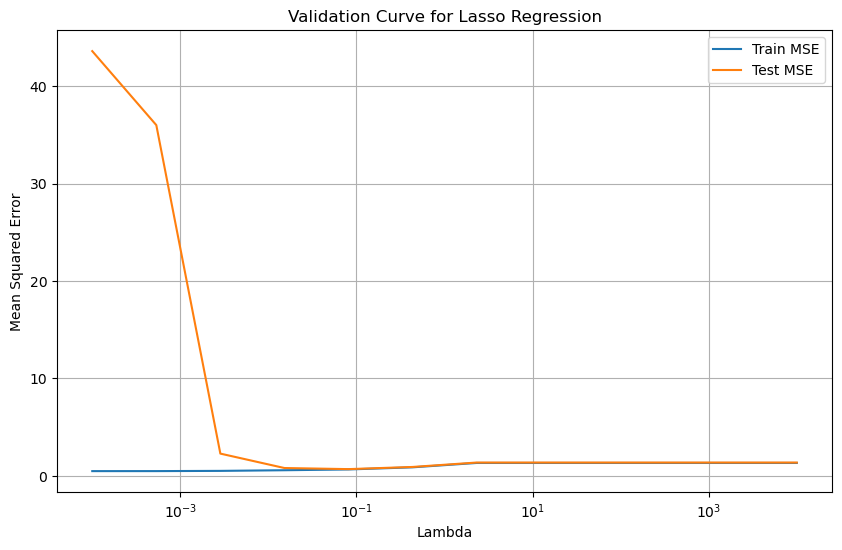

In [20]:
# Plot the average MSE-test and MSE-train against the different values of lambda
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, mean_train_mse, label='Train MSE')
plt.semilogx(lambdas, mean_test_mse, label='Test MSE')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Validation Curve for Lasso Regression')
plt.legend()
plt.grid(True)
plt.show()

When you have *more than one* hyperparameter, you will want to fit the model to all the possible combinations of hyperparameters. This is done in an approch called `Grid Search`, which is implementet in `sklearn.model_selection` as `GridSearchCV`

> **Ex. 12.2.5:** To get to know `Grid Search`, we want to implement it in one dimension. Using `GridSearchCV`, implement the Lasso, with the same lambdas as before (`lambdas =  np.logspace(-4, 4, 12)`), 10-fold CV and (negative) mean squared error as the scoring variable. Which value of Lambda gives the lowest test error? 

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Define lambda values to search through
lambdas = np.logspace(-4, 4, 12)

# Create the pipeline
pipeline = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),  # Add polynomial features of degree 3
    StandardScaler(),  # Scale the features to mean zero and unit std
    Lasso()  # Lasso regression model
)

# Define the grid of parameters to search
param_grid = {'lasso__alpha': lambdas}

# Create GridSearchCV object with 10-fold CV and negative mean squared error scoring
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10,
                           scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameters and corresponding negative mean squared error
best_lambda_grid = grid_search.best_params_['lasso__alpha']
best_neg_mse = grid_search.best_score_

# Print the best lambda and corresponding negative mean squared error
print(f"The best lambda found using GridSearchCV: {best_lambda_grid}")
print(f"Negative Mean Squared Error with best lambda: {best_neg_mse}")


/Users/ninajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.023e+03, tolerance: 2.592e+00
  model = cd_fast.enet_coordinate_descent(
/Users/ninajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.074e+03, tolerance: 2.545e+00
  model = cd_fast.enet_coordinate_descent(
/Users/ninajensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

The best lambda found using GridSearchCV: 0.01519911082952933
Negative Mean Squared Error with best lambda: -0.6397319483120305


> **Ex. 12.1.6 BONUS** Now set `lambdas =  np.logspace(-4, 4, 100)`, and repeat the previous now with RandomizedSearchCV with `n_iter=12`.

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Define lambda values to search through
lambdas = np.logspace(-4, 4, 100)

# Define the parameter distribution for randomized search
param_dist = {'lasso__alpha': lambdas}

# Create RandomizedSearchCV object with 12 iterations and negative mean squared error scoring
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=12,
                                   scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the randomized search to the data
random_search.fit(X, y)

# Get the best parameters and corresponding negative mean squared error
best_lambda_random = random_search.best_params_['lasso__alpha']
best_neg_mse_random = random_search.best_score_

# Print the best lambda and corresponding negative mean squared error
print(f"The best lambda found using RandomizedSearchCV: {best_lambda_random}")
print(f"Negative Mean Squared Error with best lambda: {best_neg_mse_random}")

The best lambda found using RandomizedSearchCV: 0.04641588833612782
Negative Mean Squared Error with best lambda: -0.6862927564159687
